Cross section requires the incident kinetic energy $KE_{inc}$ and the interacting kinetic energy $KE_{int}$.

$KE_{inst}$ is the kinetic energy from the beam instrumentation and $KE_{ff}$ is the kinetic energy at the front face of the TPC when the particle first enters LAr.

$$
KE_{ff} = KE_{inst} - \Delta E_{loss}
$$

$\Delta E_{loss}$ is the the energy lost by by the beam particle from the instrumentation to the front face, this needs to be estimating in simulation, then applied to data.

$$
KE_{int} = KE_{ff} - \Delta E_{deposit}
$$

$\Delta E_{deposit}$ can be found in two ways:

 - find $\frac{dE}{dx}$ using the bethe bloch formula from $KE_{ff}$ and then $\int\frac{dE}{dx} dx$
 - use the SCE corrected estimate of the energy deposited at a trejctory point from the calorimetry object, $\sum\Delta E_{calo}$



In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from python.analysis import cross_section, Fitting
from python.analysis import Master, Plots, vector, BeamParticleSelection
import json

import awkward as ak
import copy
import matplotlib.pyplot as plt
import matplotlib
import mplcyberpunk
import numpy as np
import pandas as pd

from matplotlib.backends.backend_pdf import PdfPages
from particle import Particle

from rich import print

# plt.style.use("cyberpunk")
# plt.rcParams["figure.dpi"] = 140
cross_section.SetPlotStyle(extend_colors = True, dpi = 140)

def hist_glow(alpha = 0.03, n = 5, width = 1.05):
    ax = plt.gca()
    for patch in ax.get_children()[:-1]: # last patch in children is the grid
        if type(patch) not in [matplotlib.patches.Polygon, matplotlib.patches.Rectangle]: continue # only add glow to histogram patches
        for i in range(1, n + 1):
            new_patch = copy.copy(patch)

            if new_patch.get_edgecolor() == (0, 0, 0, 0):
                edgecolor = new_patch.get_facecolor()
            else:
                edgecolor = new_patch.get_edgecolor()

            new_patch.set(alpha = alpha, linewidth = new_patch.get_linewidth() + (width * i), edgecolor = edgecolor, facecolor = new_patch.get_facecolor(), zorder = 0.6) # grid lines are hardcoded at zorder 0.5
            ax.add_patch(new_patch)


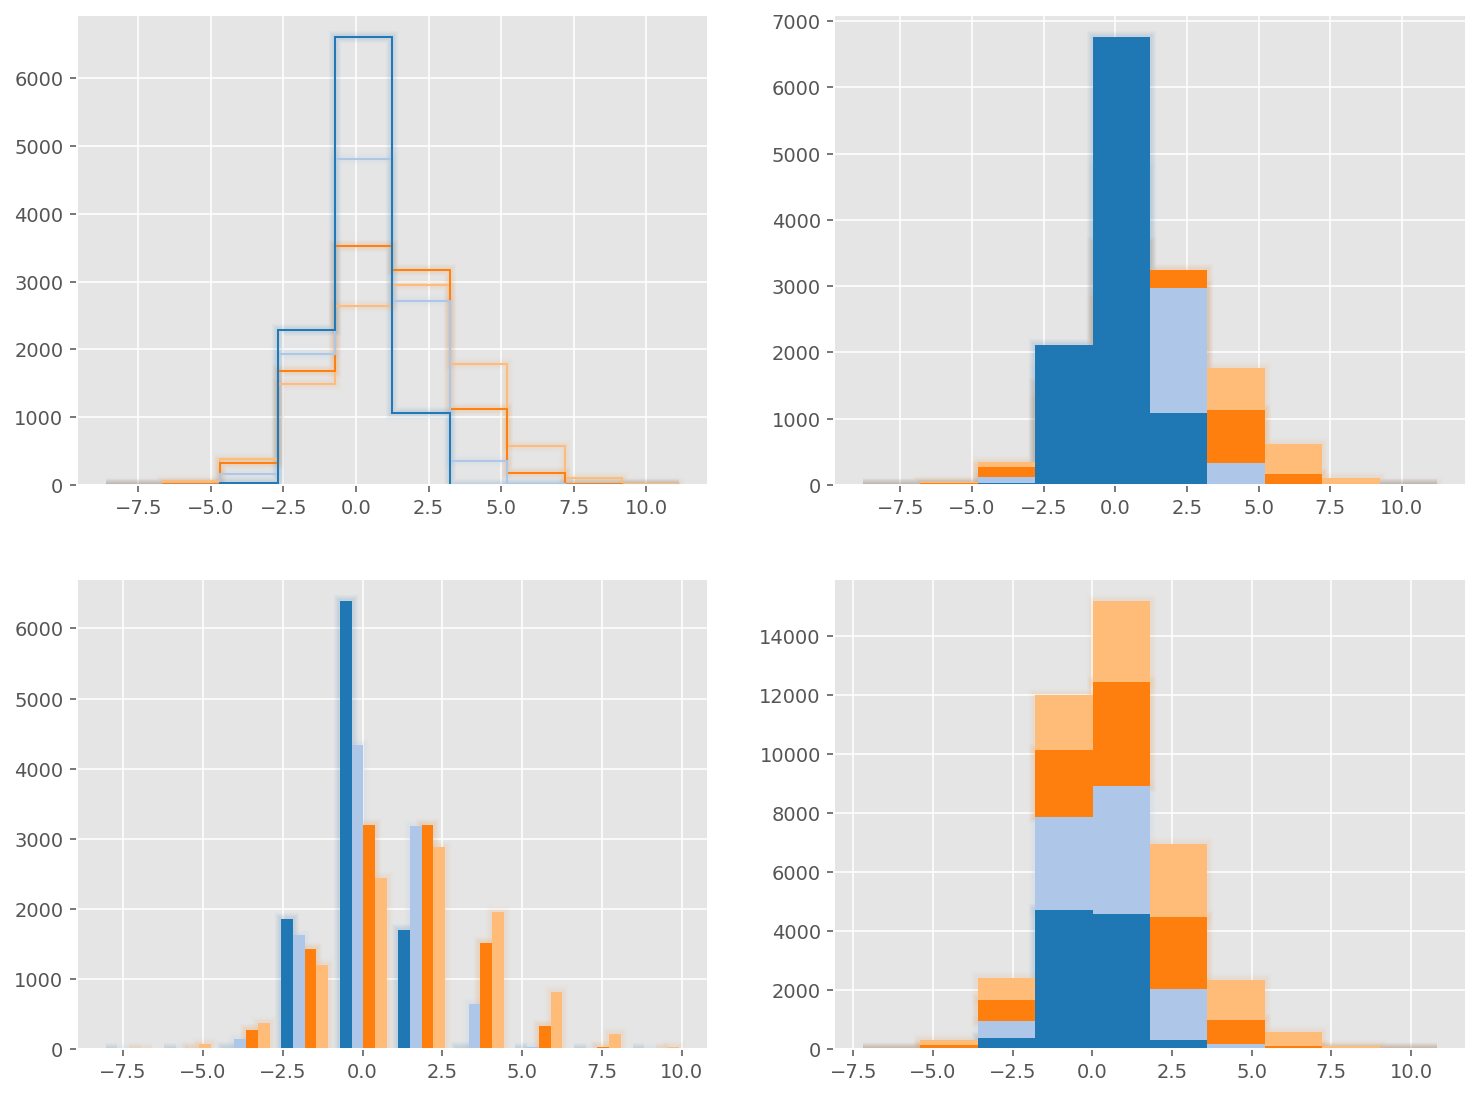

In [2]:
plt.subplots(2, 2, figsize = (6.4 * 2, 4.8 * 2))

mode = ["step", "stepfilled", "bar", "barstacked"]
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.hist(np.random.normal((0, 0.5, 1, 1.5), (1, 1.5, 2, 2.5), (10000, 4)), stacked = False, histtype = mode[i])
    hist_glow(n = 5)


# Event Selection

In [12]:
config = "work/2023/cex_analysis_1GeV_config.json"
args = cross_section.ApplicationArguments.ResolveConfig(cross_section.LoadConfiguration(config))
beam_quality_fits = {"mc" : args.mc_beam_quality_fit, "data" : args.data_beam_quality_fit}

with open(args.mc_beam_scraper_fit, "r") as file:
    beam_scraper_fits = json.load(file)

for f in beam_quality_fits:
    with open(beam_quality_fits[f], "r") as file:
        beam_quality_fits[f] = json.load(file)

mc = Master.Data(args.mc_file, nTuple_type = Master.Ntuple_Type.PDSP, nEvents = -1)
# data = Master.Data(args.data_file, nTuple_type = Master.Ntuple_Type.PDSP)

# mask = BeamParticleSelection.CreateDefaultSelection(mc, beam_quality_fits = beam_quality_fits["mc"], return_table = False)
mask = BeamParticleSelection.CreateDefaultSelection(mc, beam_quality_fits = beam_quality_fits["mc"], return_table = False, scraper = True, scraper_fits = beam_scraper_fits, scraper_cut = 1.4, scraper_KE_range = 1)
mc.Filter([mask], [mask])
 
mask = mc.trueParticles.pdg[:, 0] == 211 #! for this study only, select true pions

mc.Filter([mask], [mask])

# samples = {"mc" : mc, "data": data}

number of entries before|after PiBeamSelection: 298194|170238
number of entries before|after PandoraTagCut: 298194|245977
number of entries before|after CaloSizeCut: 298194|247361


/home/sb16165/anaconda3/envs/python3_10_0/lib/python3.10/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: divide by zero encountered in divide
  result = getattr(ufunc, method)(
/home/sb16165/anaconda3/envs/python3_10_0/lib/python3.10/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in divide
  result = getattr(ufunc, method)(


number of entries before|after MichelScoreCut: 298194|230193
number of entries before|after BeamQualityCut: 298194|177056
number of entries before|after APA3Cut: 298194|270725
number of entries before|after MedianDEdXCut: 298194|198023
[0.0621, 1.34, -0.375, -0.78, 0.491, 0.597, ... -0.0171, -0.764, 0.234, 0.442, 0.45]
[-0.269, -0.864, -0.479, 0.0982, -0.367, ... 0.0356, -0.932, -0.383, -0.831, 0.258]
number of entries before|after BeamScraper: 298194|207273
                 number of events which pass the cut  single efficiency  \
no selection                                298194.0         100.000000   
PiBeamSelection                             170238.0          57.089680   
PandoraTagCut                               245977.0          82.488917   
CaloSizeCut                                 247361.0          82.953044   
MichelScoreCut                              230193.0          77.195718   
BeamQualityCut                              177056.0          59.376111   
APA3Cut     

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to filters.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to filename.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to nTuple_type.
  warnings.warn(f"Couldn't apply filters to {var}.")


In [13]:
save = False
if save: pdf = PdfPages("beam_KE_plots.pdf")
def Save():
    if save:
        try:
            pdf.savefig()
        except AttributeError:
            pass

In [14]:
class labels:
    KE_reco_inst = "$KE^{reco}_{inst}$"
    KE_reco_ff = "$KE^{reco}_{ff}$"
    KE_reco_int = "$KE^{reco}_{int}$"
    KE_reco_int_bb = "$KE^{reco}_{int, bb}$"
    KE_reco_int_calo = "$KE^{reco}_{int, calo}$"
    Delta_E_reco = "$\Delta E^{reco}$"
    Delta_E_reco_bb = "$\Delta E^{reco}_{bb}$"
    Delta_E_reco_calo = "$\Delta E^{reco}_{calo}$"
    KE_true_ff = "$KE^{true}_{ff}$"
    KE_true_int = "$KE^{true}_{int}$"
    Delta_E_true = "$\Delta E^{true}$"
    mu_KE_reco_inst_minus_KE_true_ff = "$\mu($" + KE_reco_inst + "$-$" + KE_true_ff + "$)$"
    MeV = "(MeV)"

# $KE^{true}_{ff}$ and $KE^{reco}_{inst}$

In [15]:
KE_reco_inst = cross_section.KE(mc.recoParticles.beam_inst_P, Particle.from_pdgid(211).mass)
KE_true_ff = mc.trueParticles.KE_front_face

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 [array([   0.,   20.,   40.,   60.,   80.,  100.,  120.,  140.,  160.,
          180.,  200.,  220.,  240.,  260.,  280.,  300.,  320.,  340.,
          360.,  380.,  400.,  420.,  440.,  460.,  480.,  500.,  520.,
          540.,  560.,  580.,  600.,  620.,  640.,  660.,  680.,  700.,
          720.,  740.,  760.,  780.,  800.,  820.,  840.,  860.,  880.,
          900.,  920.,  940.,  960.,  980., 1000., 1020., 1040., 1060.,
         1080., 1100., 1120., 1140., 1160., 1180., 1200., 1220., 1240.,
         1260., 1280., 1300., 1320., 1340., 1360., 1380., 1400., 1420.,
         1440., 1460., 1480., 1500., 1520., 1540., 1560., 1580., 1600.,
         1620., 1640., 1660., 1680., 1700., 1720., 1740., 1760., 1780.,
         1800., 1820., 1840., 1

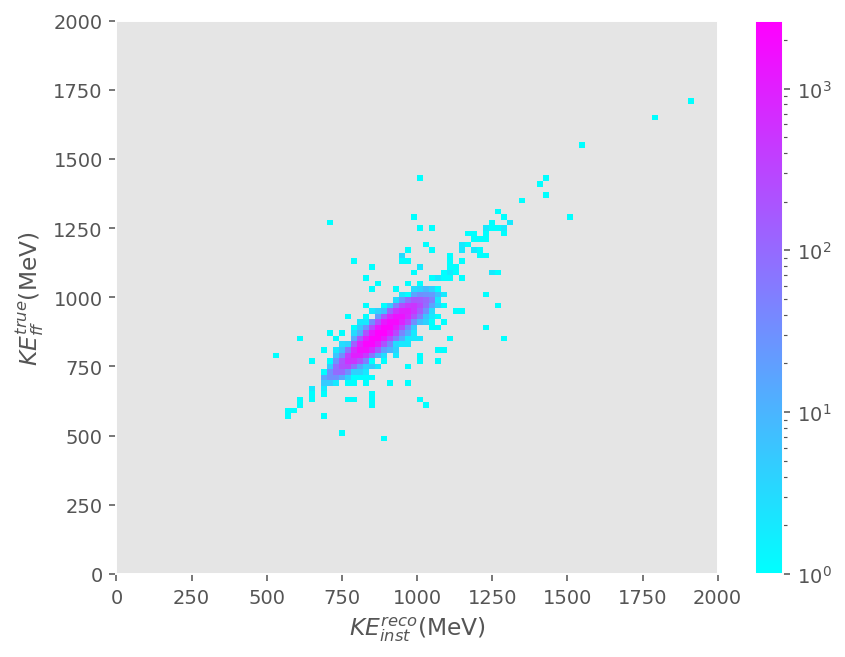

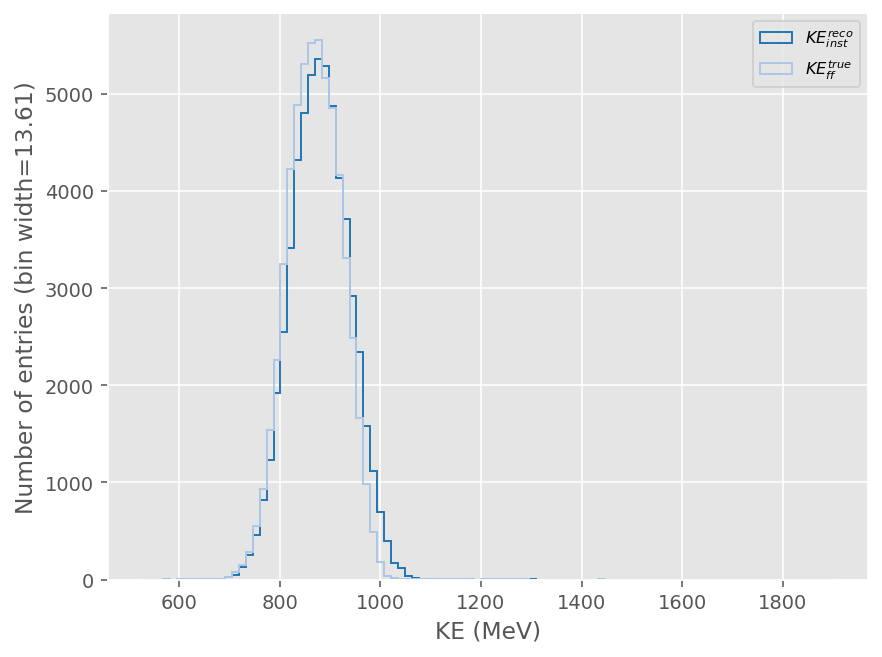

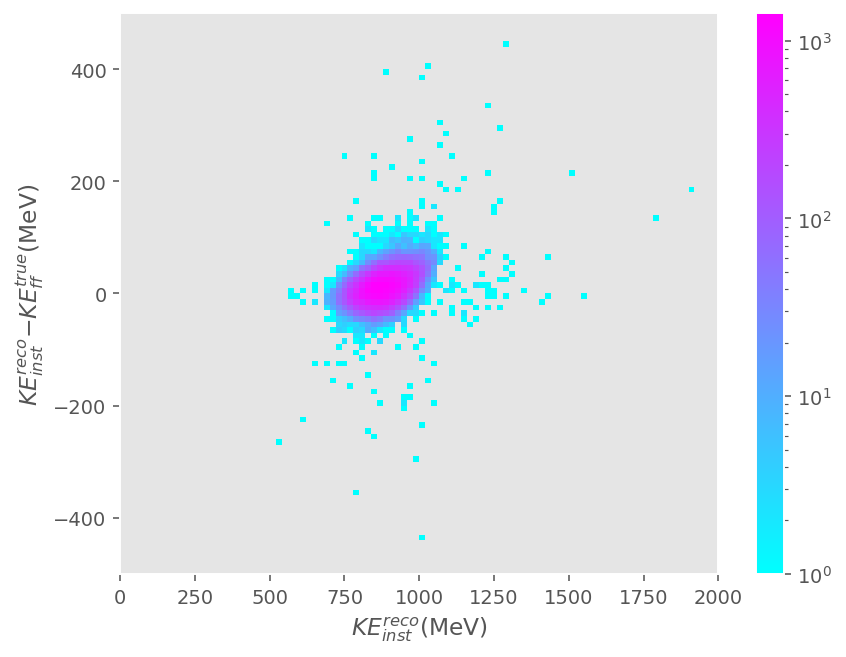

In [16]:
Plots.PlotHist2D(KE_reco_inst[KE_true_ff > 0], KE_true_ff[KE_true_ff > 0], cmap = "cool", xlabel = labels.KE_reco_inst + labels.MeV, ylabel = labels.KE_true_ff + labels.MeV, x_range = [0, 2000], y_range = [0, 2000])
Save()

Plots.PlotHistComparison([KE_reco_inst, KE_true_ff], labels = [labels.KE_reco_inst, labels.KE_true_ff], xlabel = "KE " + labels.MeV, density = False, xRange = [0, 2000])
Save()

Plots.PlotHist2D(KE_reco_inst[KE_true_ff > 0], (KE_reco_inst - KE_true_ff)[KE_true_ff > 0], cmap = "cool", xlabel = labels.KE_reco_inst + labels.MeV, ylabel = labels.KE_reco_inst  + "$-$" + labels.KE_true_ff + labels.MeV, x_range = [0, 2000], y_range = [-500, 500])


# Upstream Energy loss ($\Delta E_{loss}$)

In [17]:
def NumericalCV(bins : np.array, KE_reco_inst : np.array, KE_true_ff : np.array) -> tuple[np.array, np.array]:
    binned_data = {"KE_inst": [], "KEff_true" : [], "KE_first_true" : []}
    for i in range(len(bins)-1):
        mask = (KE_reco_inst > bins[i]) & (KE_reco_inst < bins[i + 1])
        mask = mask & (KE_true_ff > 0)

        binned_data["KE_inst"].append( KE_reco_inst[mask] )
        binned_data["KEff_true"].append( KE_true_ff[mask] )
    binned_data = {i : ak.Array(binned_data[i]) for i in binned_data}

    print(ak.num(binned_data["KE_inst"]))
    residual_energy = binned_data["KE_inst"] - binned_data["KEff_true"]

    mean_residual_energy = ak.mean(residual_energy, axis = -1)
    mean_error_residual_energy = ak.std(residual_energy, axis = -1) / np.sqrt(ak.num(residual_energy))
    return mean_residual_energy, mean_error_residual_energy


def UpstreamLossFit(bins : np.array, KE_reco_inst : np.array, KE_true_ff : np.array, cv_function : Fitting.FitFunction = None, response_function : Fitting.FitFunction = Fitting.poly2d) -> tuple[np.array, np.array]:
    if cv_function is None:
        cv = NumericalCV(bins, KE_reco_inst, KE_true_ff)
    else:
        df = pd.DataFrame({"KE_inst" : KE_reco_inst, "true_ffKE" : KE_true_ff})
        df["residual"] = df.KE_inst - df.true_ffKE
        cv = Fitting.ExtractCentralValues_df(df, "KE_inst", "residual", [-250, 250], [cv_function], bins, 50, rms_err = False)

    x = (bins[1:] + bins[:-1]) / 2
    xerr = abs(x - bins[1:])

    params = Fitting.Fit(x, cv[0], cv[1], Fitting.poly2d, plot = False, maxfev = int(5E5))
    return params


### Fit using arithmetic mean as central value in each bin

In [18]:
bins = ak.Array([700, 750, 800, 850, 900, 950, 1000, 1050, 1100])

mean_cv = NumericalCV(bins, KE_reco_inst, KE_true_ff)

central_values = {}
central_values["arithmetic_mean"] = {"value" : mean_cv[0], "error" : mean_cv[1]}

[556, 4073, 13085, 18954, 14318, 5834, 1026, 60]

### Fit using central value determined by fits 

KE_inst   true_ffKE   residual
0      773.444544  790.840367 -17.395823
1      964.471504  923.967734  40.503769
2      825.480091  798.058894  27.421197
3      888.239037  841.598619  46.640418
4      814.389800  836.152411 -21.762611
...           ...         ...        ...
58003  955.707315  910.508618  45.198697
58004  914.403921  926.720830 -12.316909
58005  854.234647  814.686840  39.547807
58006  862.575795  849.472264  13.103531
58007  858.226303  843.781870  14.444432

[58008 rows x 3 columns]

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Fitting.py:180: RuntimeWarning: invalid value encountered in power
  y = np.where(t > -alpha, np.exp(-t**2 / 2), A * (B - t)**-n)


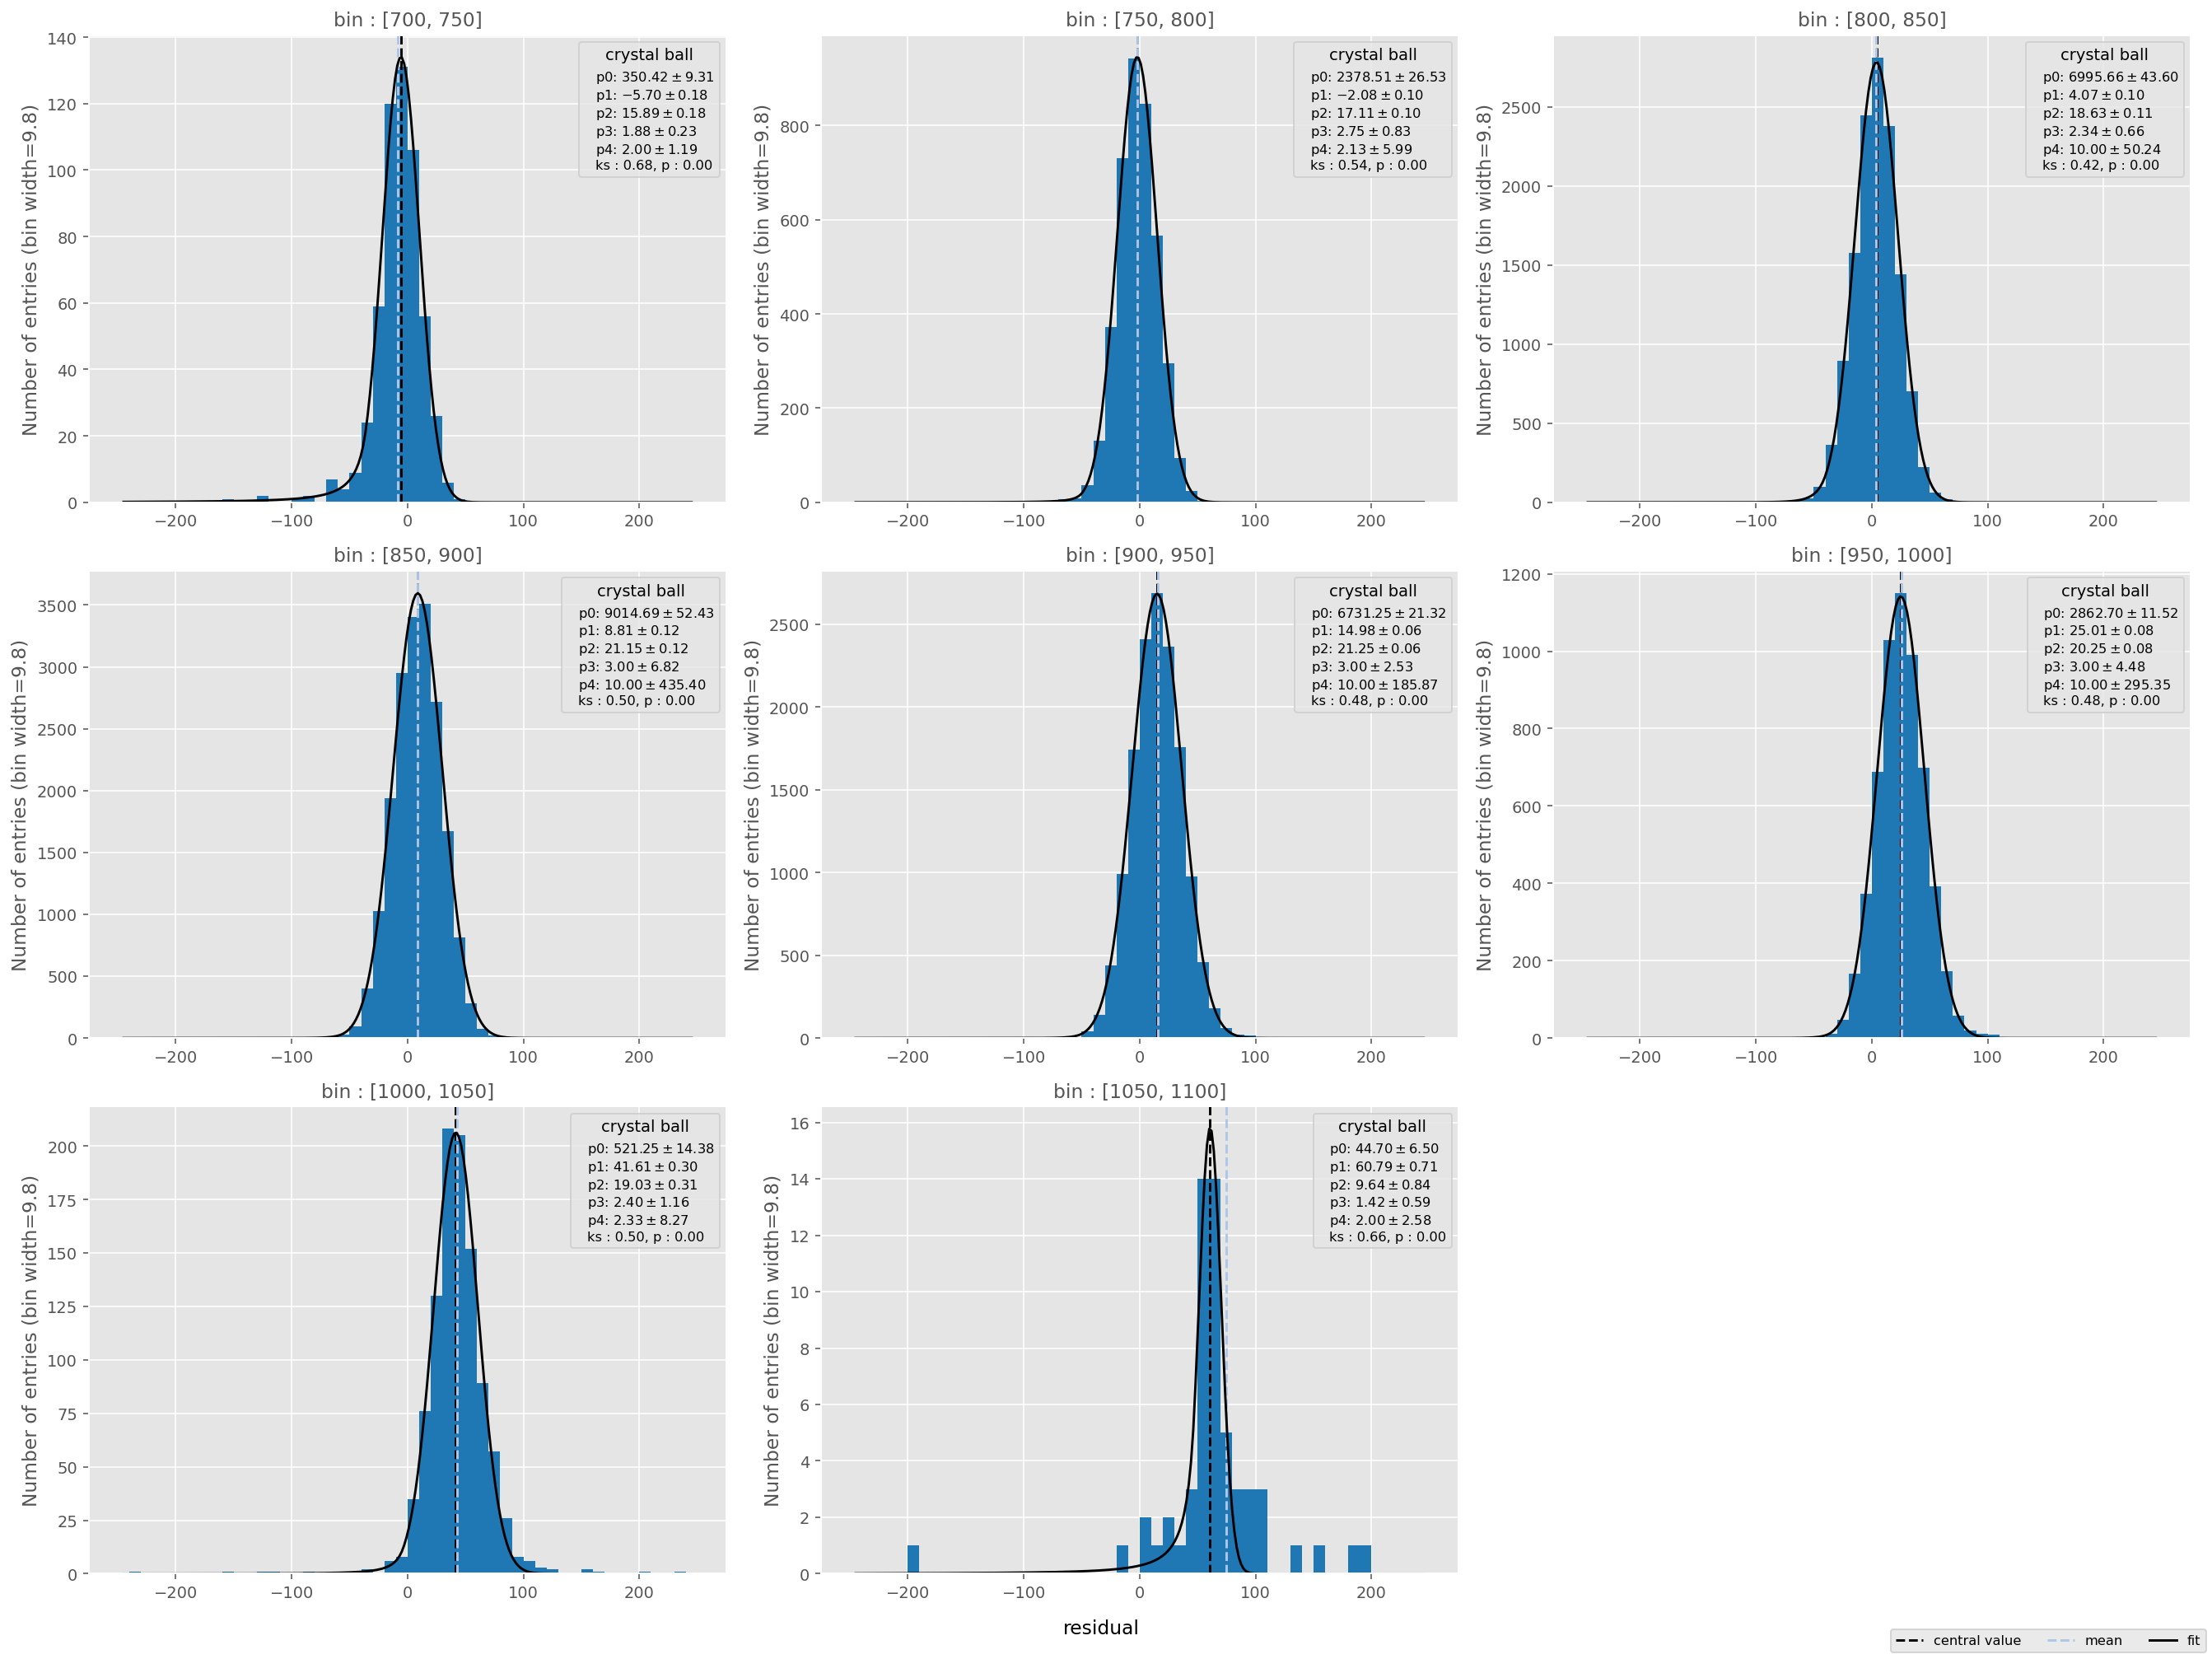

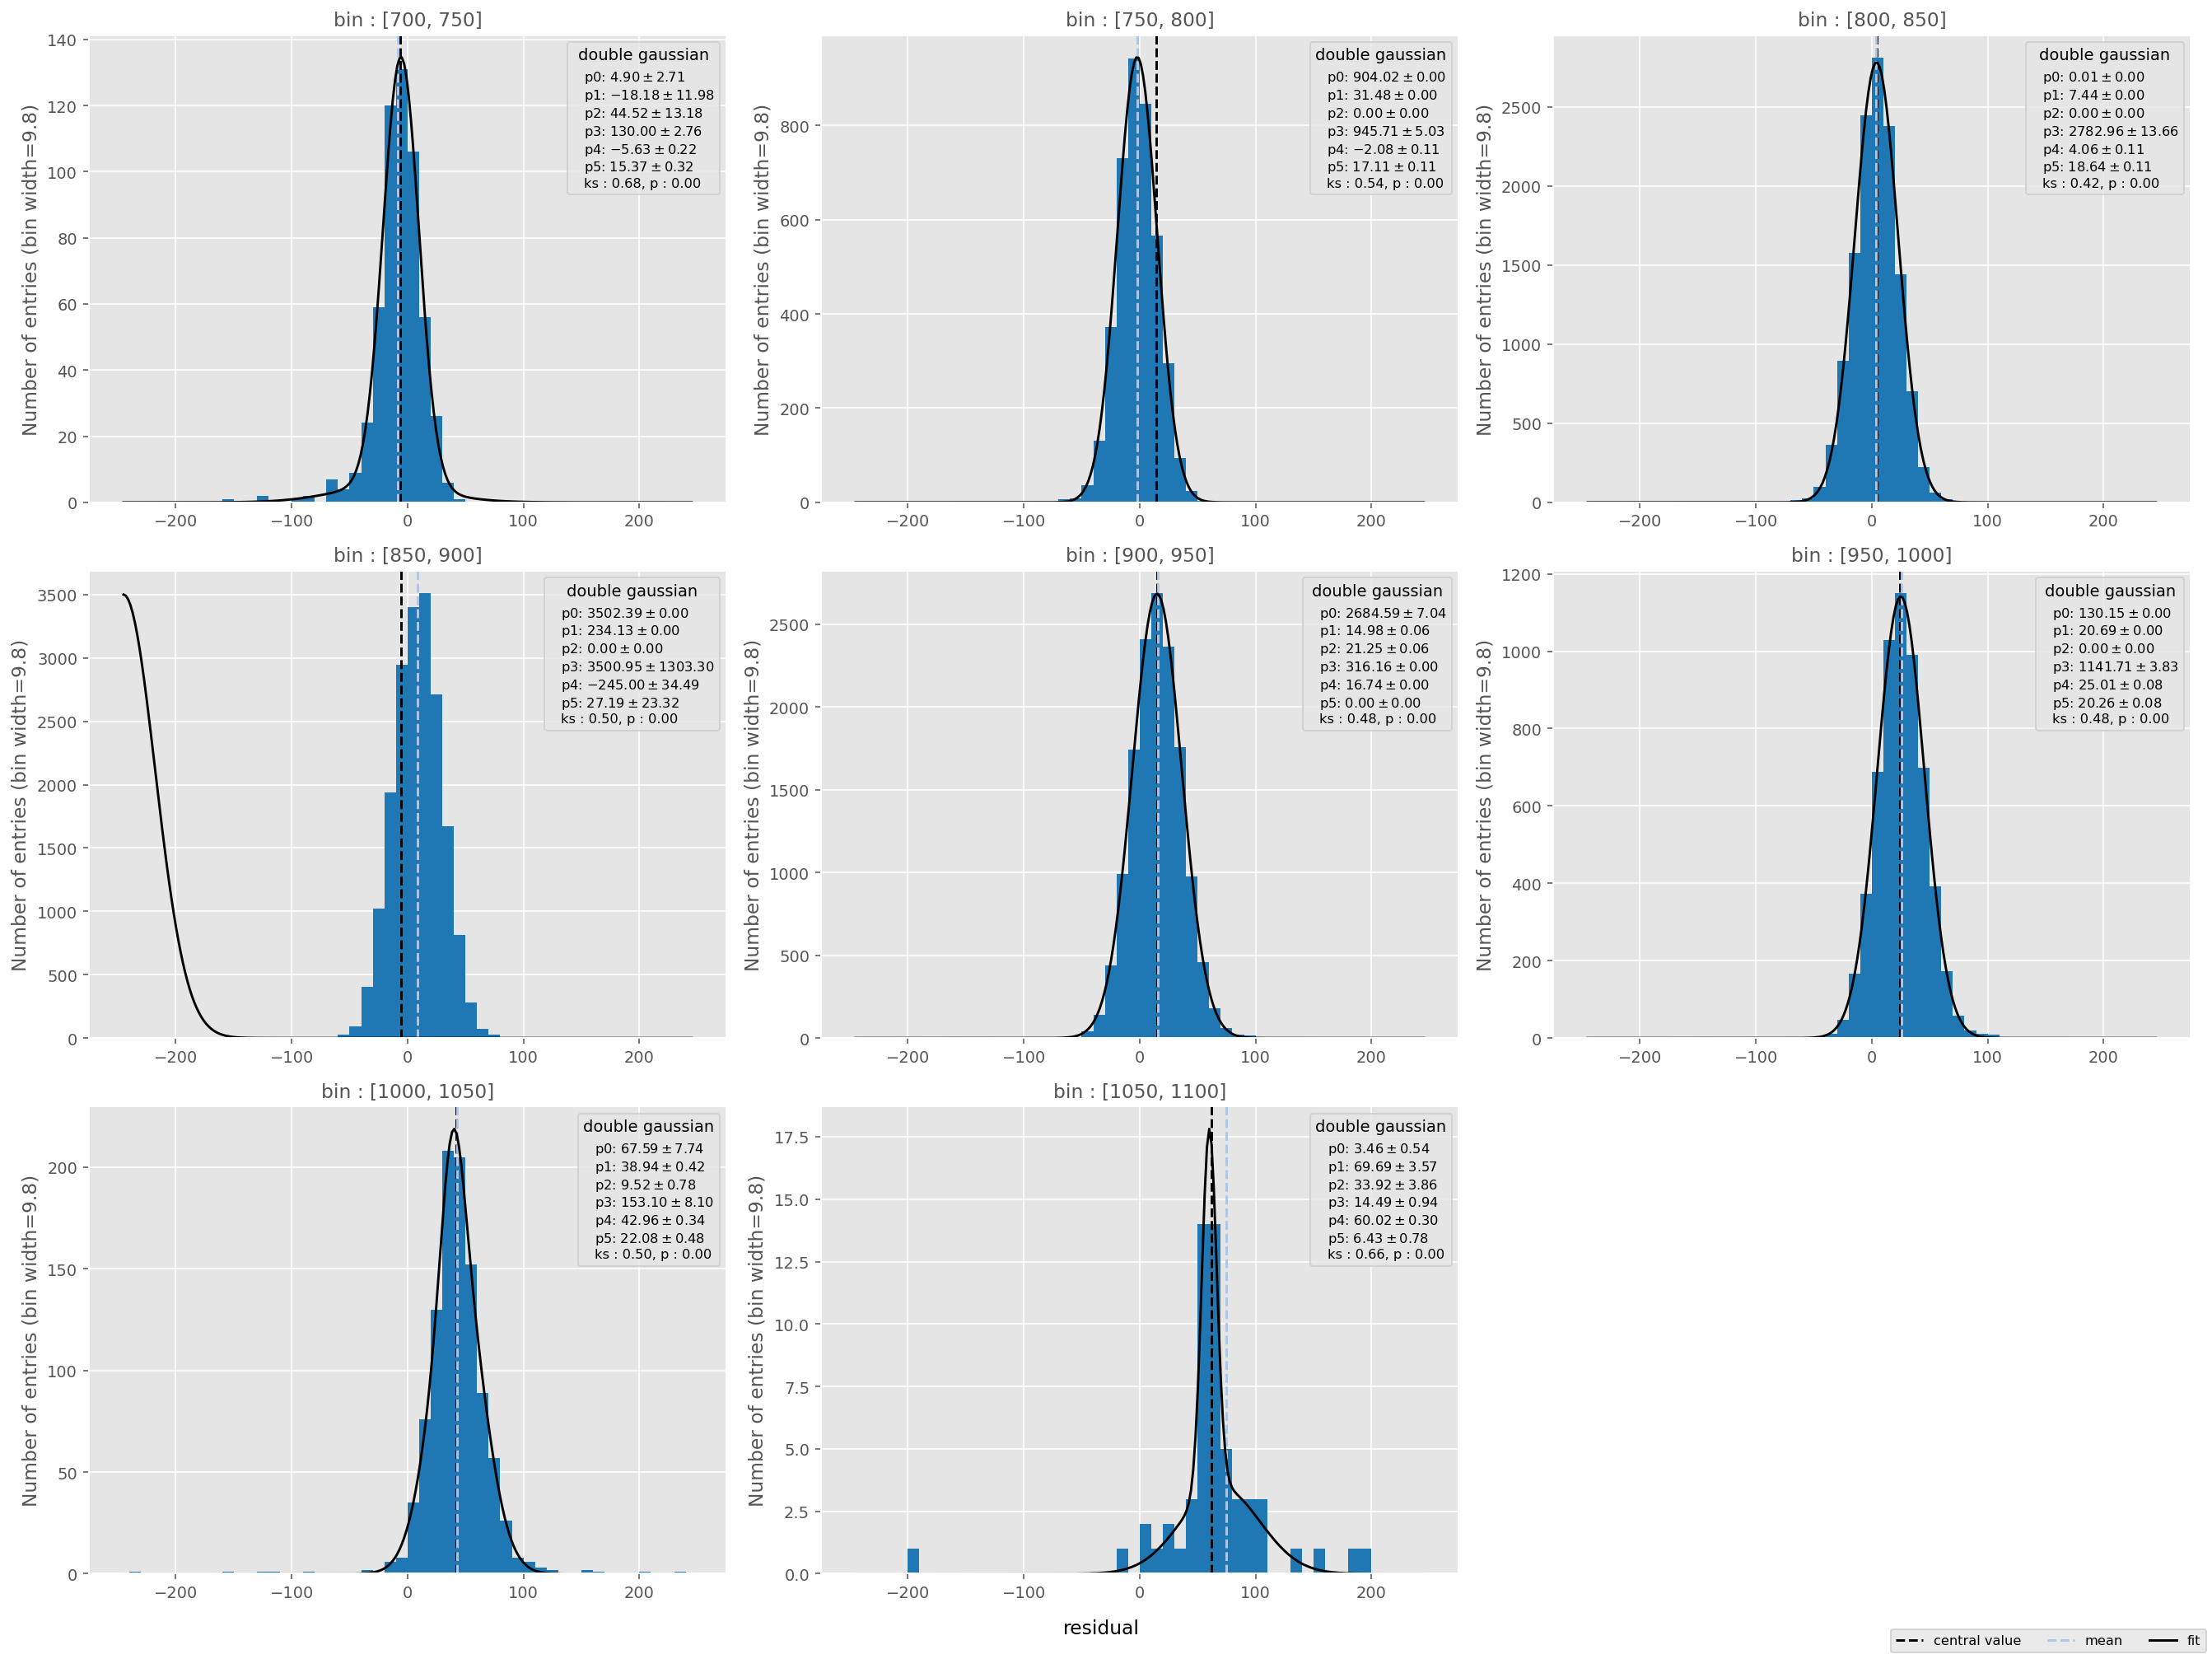

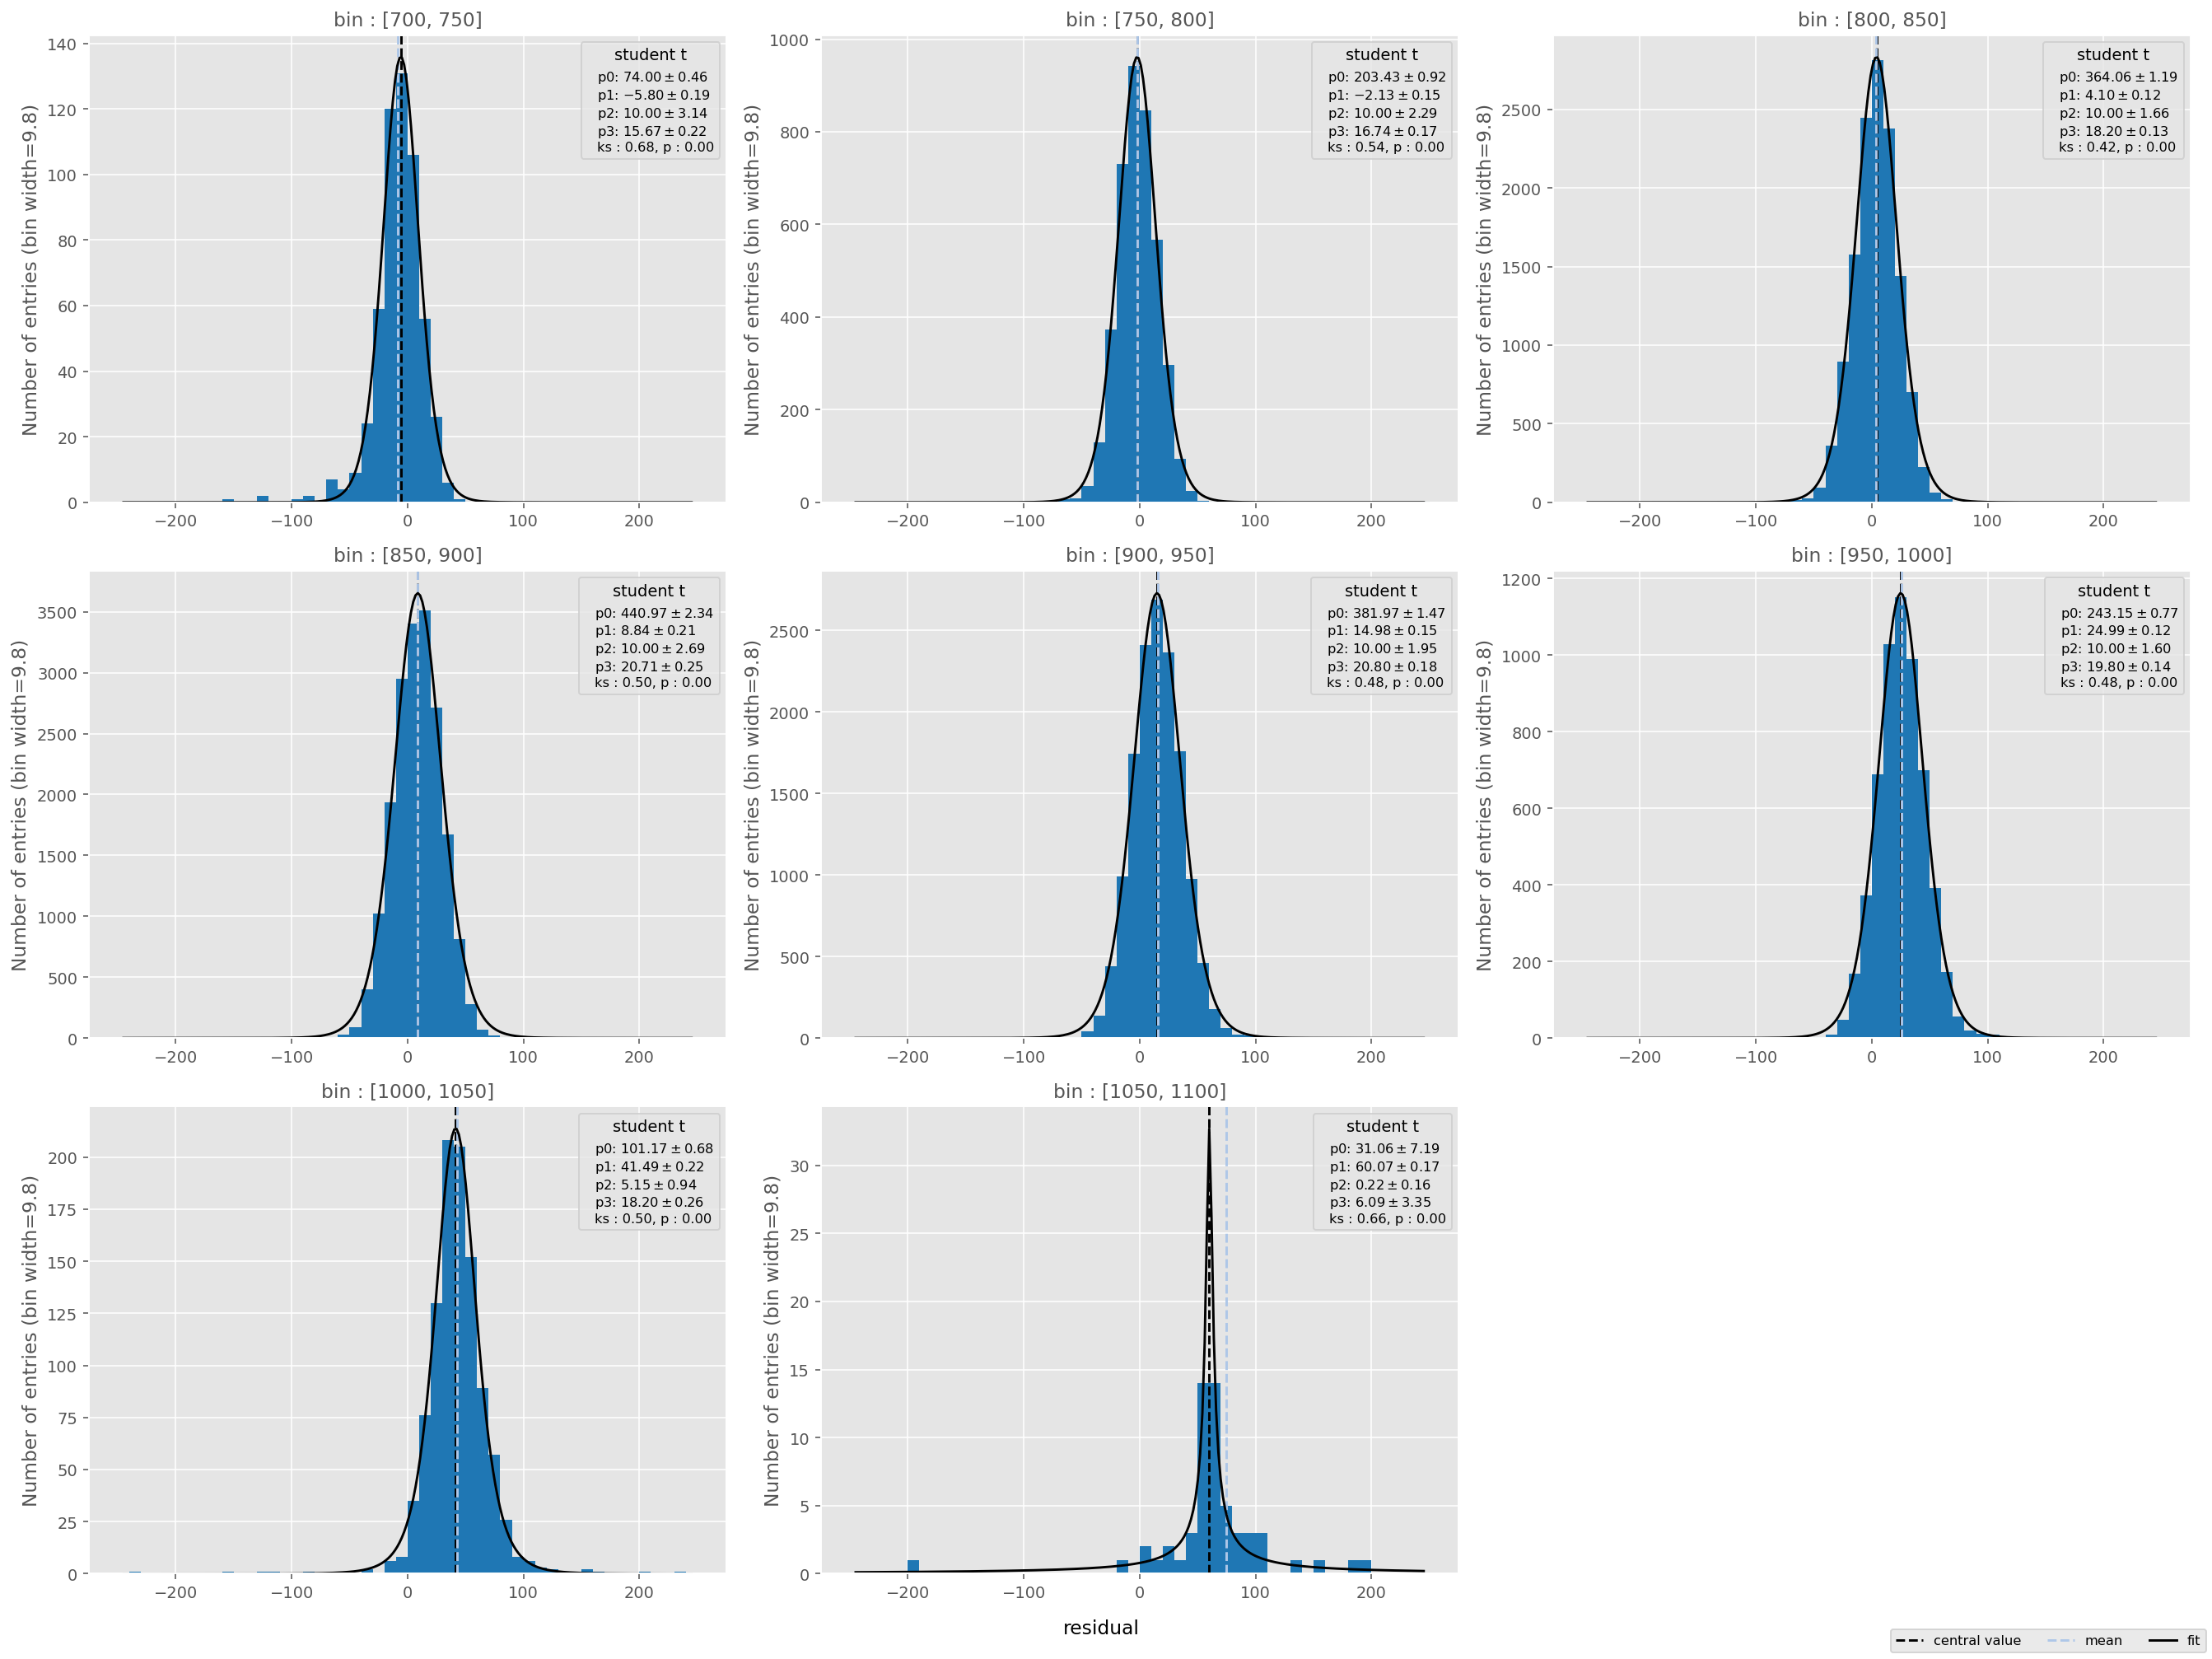

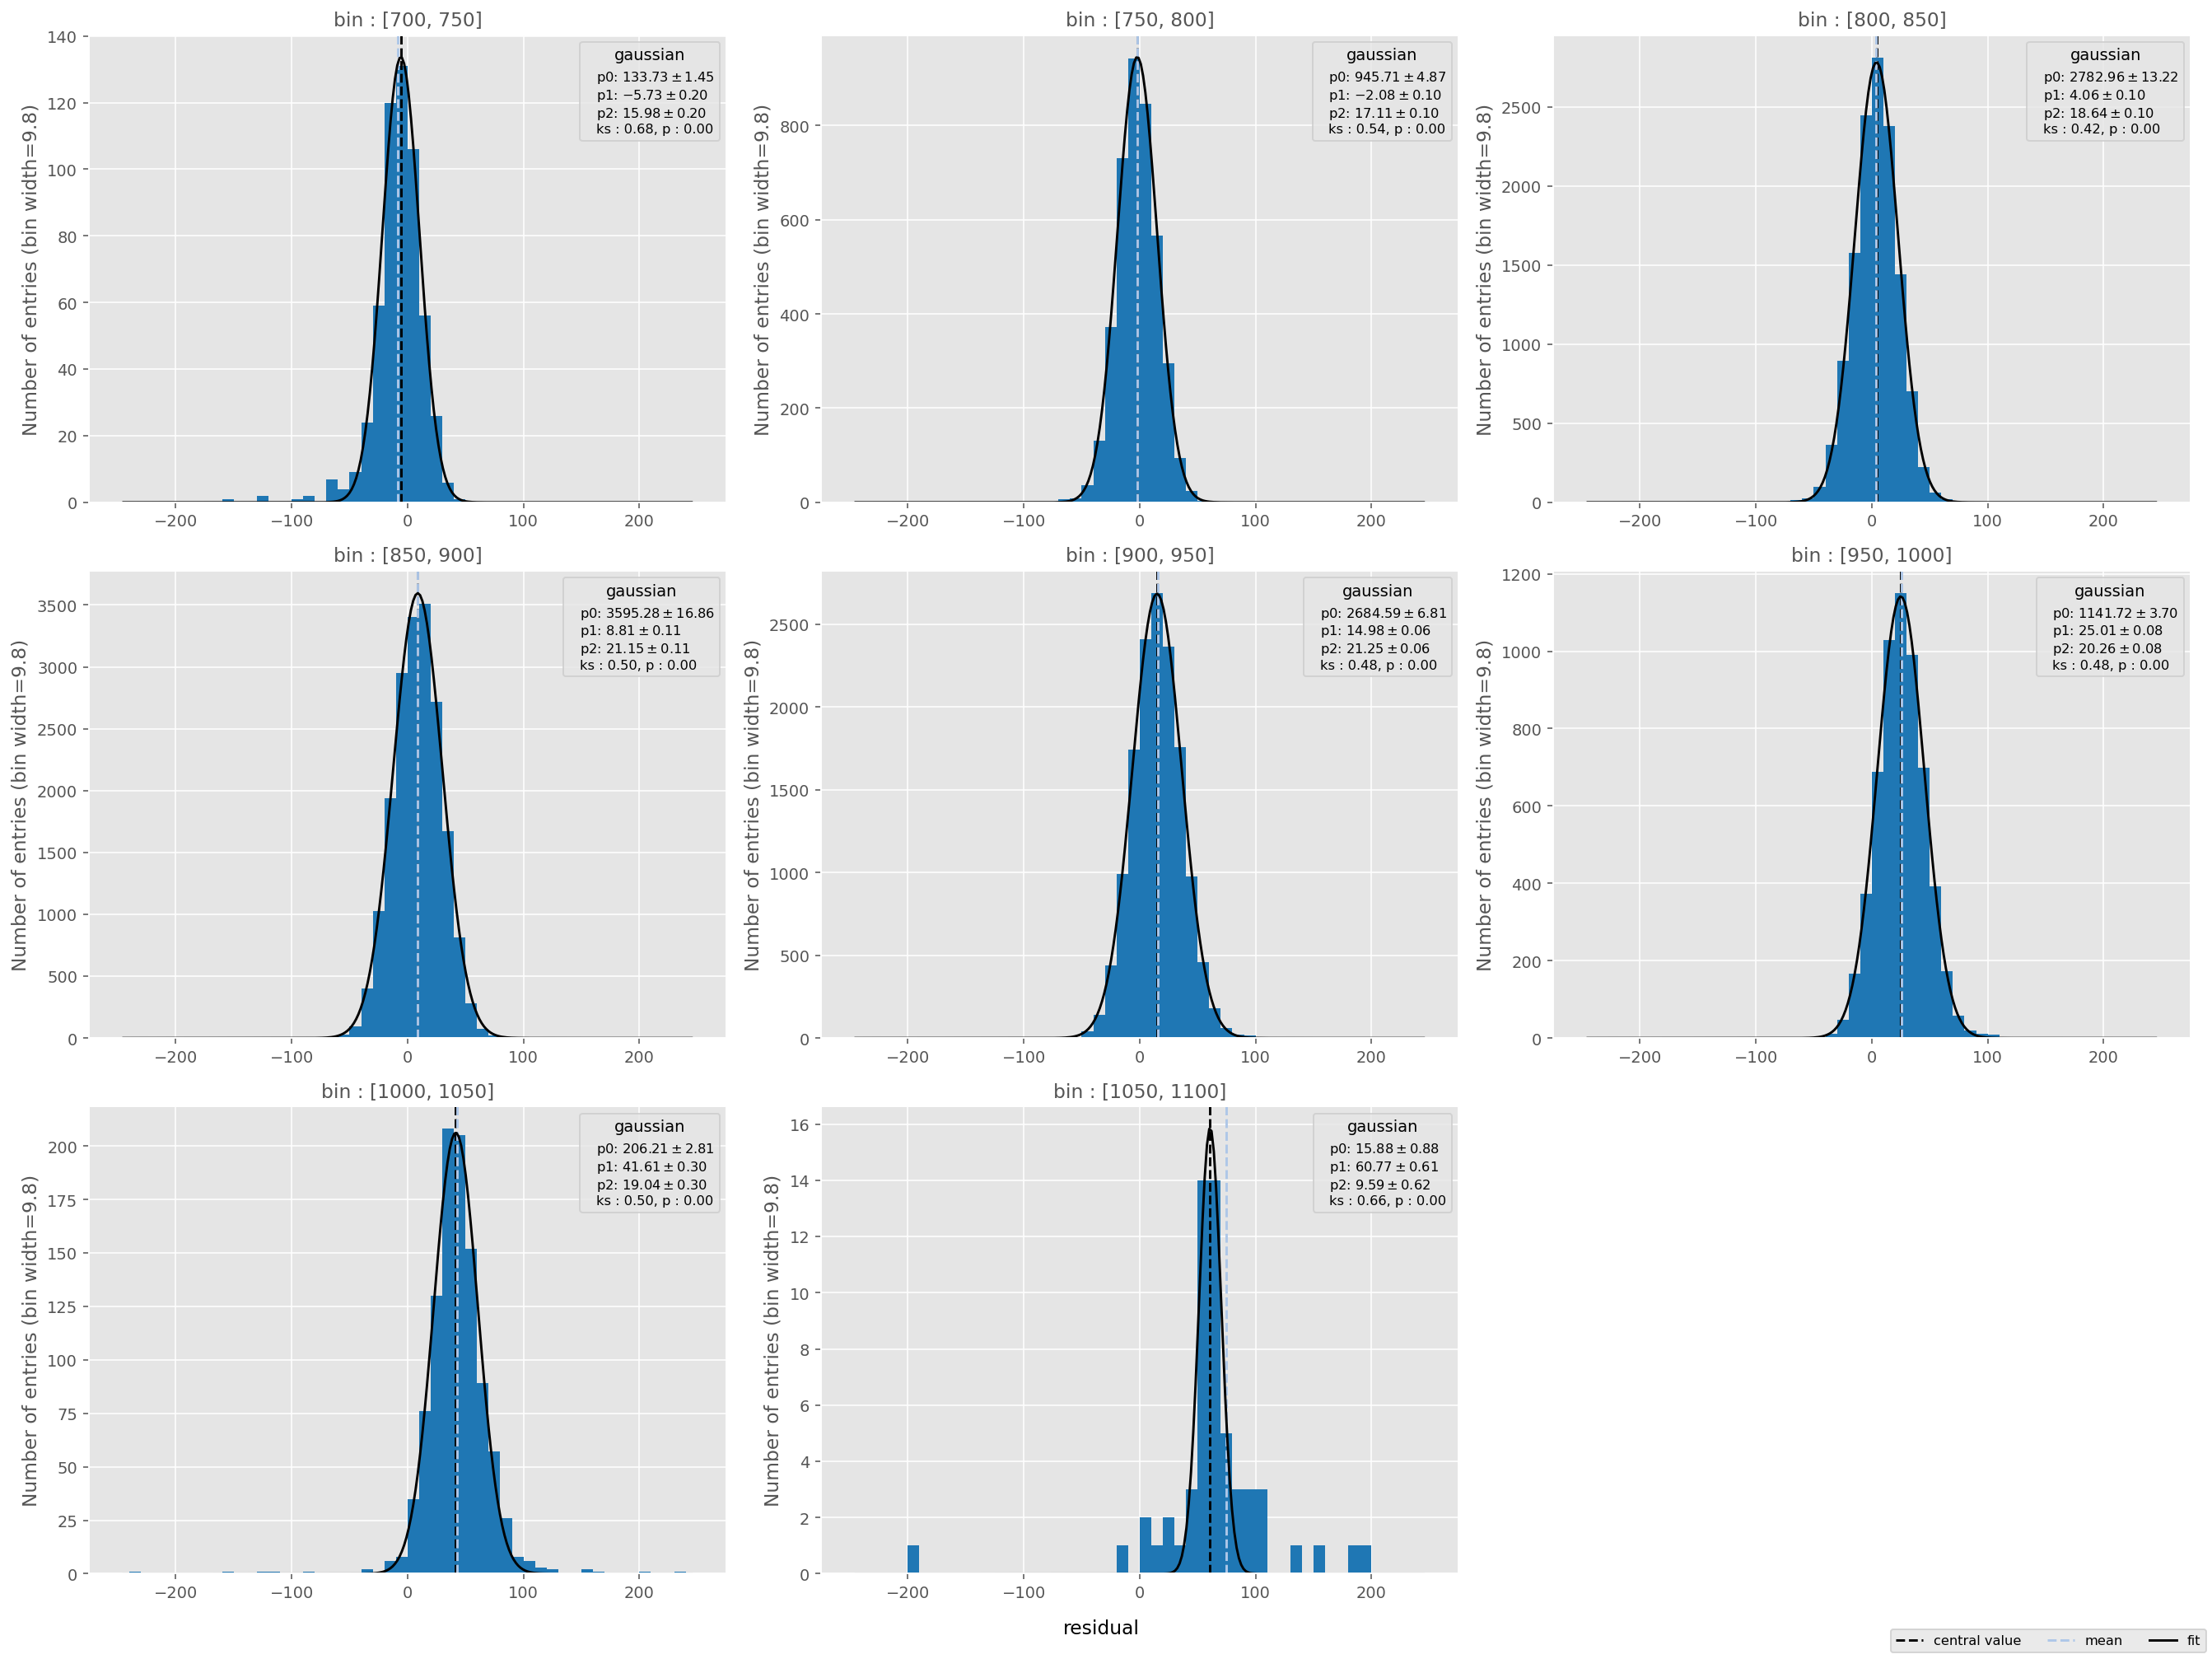

In [19]:
df = pd.DataFrame({"KE_inst" : KE_reco_inst, "true_ffKE" : KE_true_ff})
df["residual"] = df.KE_inst - df.true_ffKE
print(df)

functions = {
    "crystal_ball" : Fitting.crystal_ball,
    "double_gaussian" : Fitting.double_gaussian,
    "student_t" : Fitting.student_t,
    "gaussian" : Fitting.gaussian
}

for f in functions:
    cv = Fitting.ExtractCentralValues_df(df, "KE_inst", "residual", [-250, 250], [functions[f]], bins, 50, rms_err = False)
    central_values[f] = {"value" : cv[0], "error" : cv[1]}
    Save()


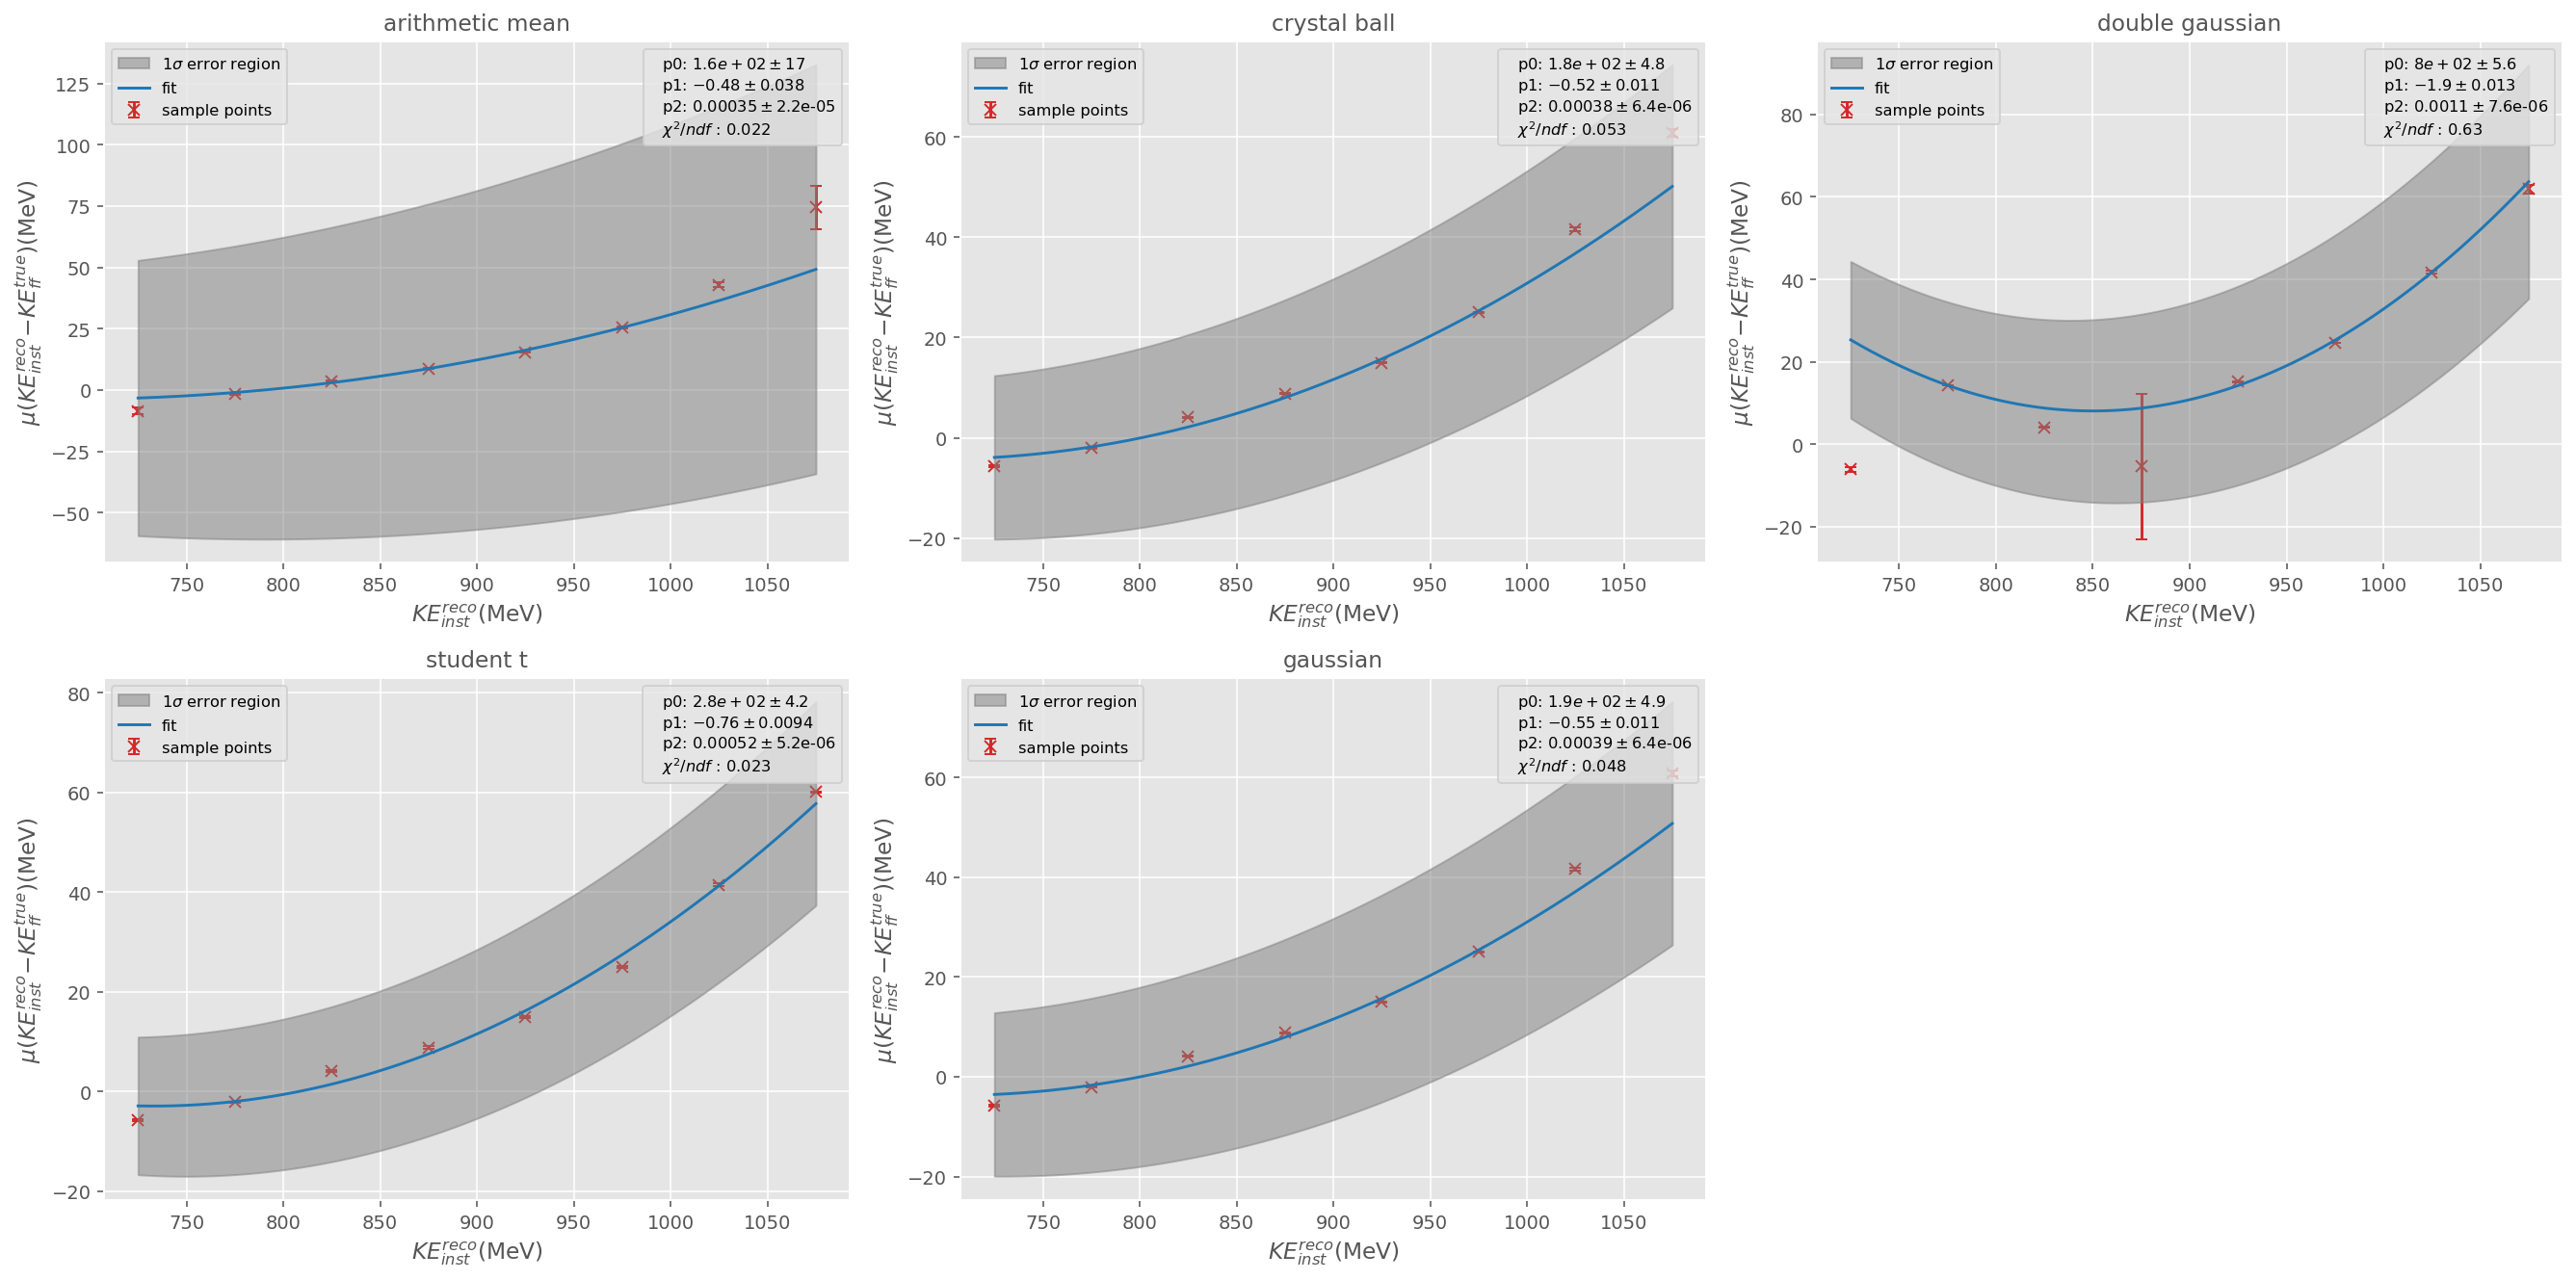

In [20]:
x = (bins[1:] + bins[:-1]) / 2
xerr = abs(x - bins[1:])

popt = {}
perr = {}
for i, cv in Plots.IterMultiPlot(central_values, True, True):
    params = Fitting.Fit(x, central_values[cv]["value"], central_values[cv]["error"], Fitting.poly2d, plot = True, xlabel = labels.KE_reco_inst + labels.MeV, ylabel = labels.mu_KE_reco_inst_minus_KE_true_ff + labels.MeV, maxfev = int(5E5))
    plt.title(cv.replace("_", " "))
    popt[cv] = params[0]
    perr[cv] = params[1]
Save()


['p0 : 1.9e+02 \\pm 4.9', 'p1 : -0.55 \\pm 0.011', 'p2 : 0.00039 \\pm 6.4e-06']

['p0 : 2.2e+02 \\pm 43', 'p1 : -0.63 \\pm 0.1', 'p2 : 0.00045 \\pm 6.3e-05']

['p0 : 1.7e+02 \\pm 13', 'p1 : -0.57 \\pm 0.03', 'p2 : 0.00043 \\pm 1.7e-05']

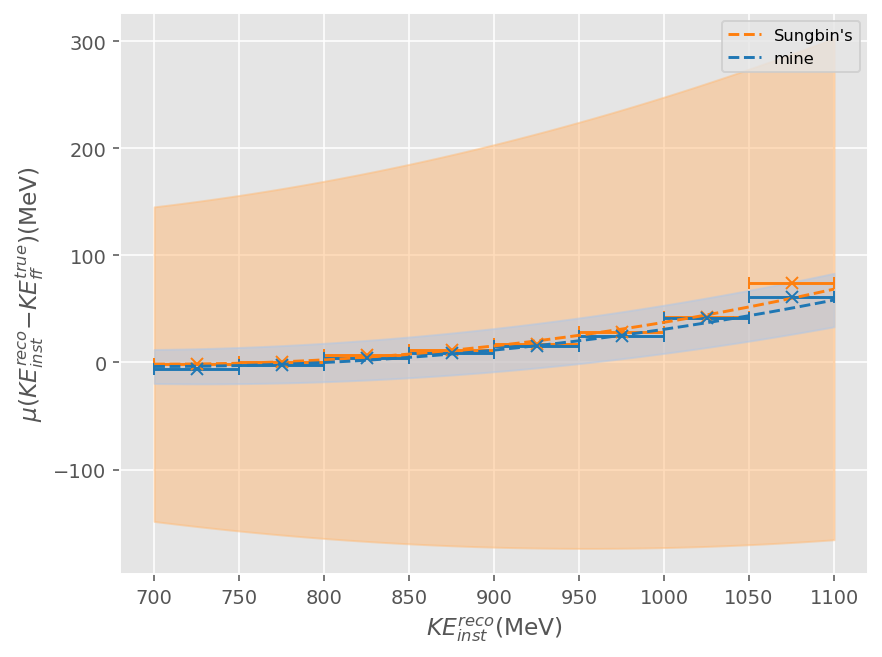

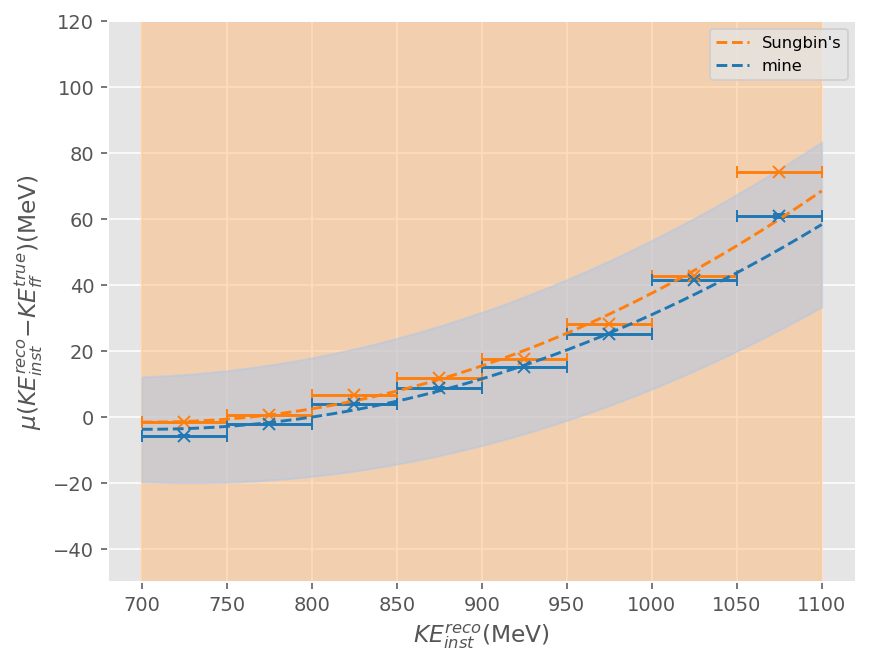

In [29]:
x_interp = np.linspace(700, 1100, 1000)

# Sungbin's correction parameters
s_popt = np.array([2.223e+02, -6.348e-01, 4.500e-04])
s_err = np.array([4.31e+01, 1.04e-01, 6.33e-05])

s_x = [725, 775, 825, 875, 925, 975, 1025, 1075]
s_y = [-1.5209125475285177, 0.5323193916349815, 6.692015209125476, 11.711026615969583, 17.642585551330797, 28.136882129277566, 42.737642585551335, 74.22053231939164]

# Kangs's correction parameters
k_popt = np.array([171.8, -0.575, 4.3e-4])
k_err = np.array([13.1, 0.03, 1.75e-5])

k_x = [725, 775, 825, 875, 925, 975, 1025]
k_y = [-18.21656050955414, -11.59235668789809, -5.222929936305732, 1.4012738853503173, 8.789808917197451, 21.783439490445858, 39.87261146496815]

for v, e in zip([popt["gaussian"], s_popt, k_popt], [perr["gaussian"], s_err, k_err]):
    print([f"p{i} : {v[i]:.2g} \pm {e[i]:.2g}" for i in range(len(v))])

def upstream_loss_fit():
    plt.figure()
    Plots.Plot(s_x, s_y, xerr = 25, marker = "x", linestyle = "", color = "C2", newFigure = False)
    Plots.Plot(x_interp, Fitting.poly2d.func(x_interp, *s_popt), newFigure = False, color = "C2", linestyle = "--", label = f"Sungbin's")
    plt.fill_between(x_interp, Fitting.poly2d.func(x_interp, *(s_popt - s_err)), Fitting.poly2d.func(x_interp, *(s_popt + s_err)), alpha = 0.5, color = "C3")

    Plots.Plot(k_x, k_y, xerr = 25, marker = "x", linestyle = "", color = "C4", newFigure = False)
    Plots.Plot(x_interp, Fitting.poly2d.func(x_interp, *k_popt), newFigure = False, color = "C4", linestyle = "--", label = f"Kang's")
    plt.fill_between(x_interp, Fitting.poly2d.func(x_interp, *(k_popt - k_err)), Fitting.poly2d.func(x_interp, *(k_popt + k_err)), alpha = 0.5, color = "C5")

    Plots.Plot(x, central_values["gaussian"]["value"], yerr = central_values["gaussian"]["error"], xerr = 25, marker = "x", linestyle = "", xlabel = labels.KE_reco_inst + labels.MeV, ylabel = labels.mu_KE_reco_inst_minus_KE_true_ff + labels.MeV, newFigure = False)
    Plots.Plot(x_interp, Fitting.poly2d.func(x_interp, *popt["gaussian"]), newFigure = False, color = "C0", linestyle = "--", label = f'mine')
    plt.fill_between(x_interp, Fitting.poly2d.func(x_interp, *(popt["gaussian"] - perr["gaussian"])), Fitting.poly2d.func(x_interp, *(popt["gaussian"] + perr["gaussian"])), alpha = 0.5, color = "C1")


    plt.legend()
    return

upstream_loss_fit()
Save()

upstream_loss_fit()
plt.ylim(-50, 120)
Save()

### Comparison

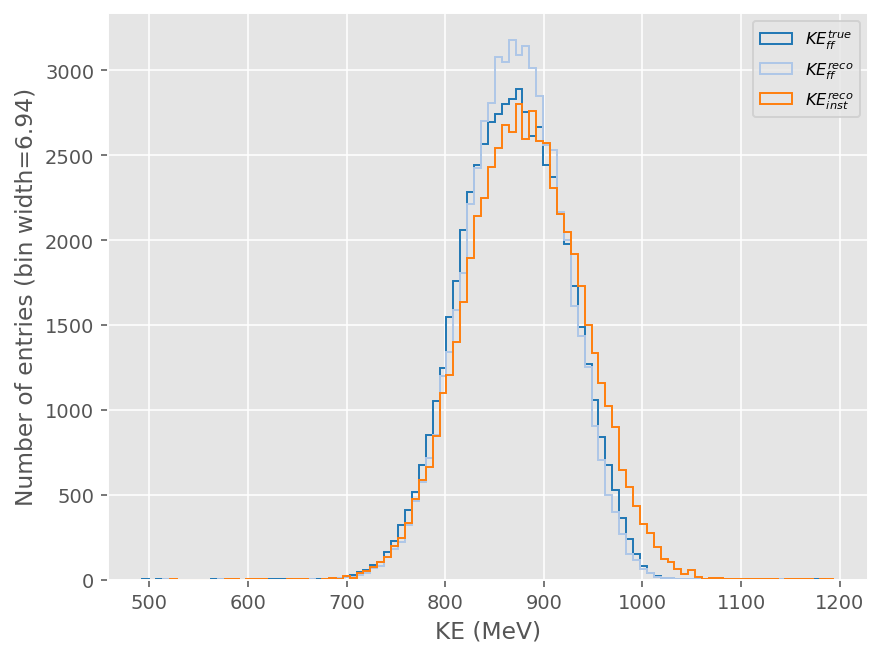

In [22]:
reco_ffKE = KE_reco_inst - cross_section.UpstreamEnergyLoss(KE_reco_inst, Fitting.poly2d.func, popt["gaussian"])
Plots.PlotHistComparison([KE_true_ff, reco_ffKE, KE_reco_inst], labels = [labels.KE_true_ff, labels.KE_reco_ff, labels.KE_reco_inst], xlabel = "KE " + labels.MeV, xRange = [0, 1200], density = False)
Save()


# Energy loss in TPC

In [23]:
dE_true = KE_true_ff - mc.trueParticles.beam_traj_KE[:, -2]
dE_calo = cross_section.DepositedEnergy(mc, reco_ffKE, "calo")
dE_bb = cross_section.DepositedEnergy(mc, reco_ffKE, "bb")

/home/sb16165/anaconda3/envs/python3_10_0/lib/python3.10/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(
/home/sb16165/anaconda3/envs/python3_10_0/lib/python3.10/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in power
  result = getattr(ufunc, method)(


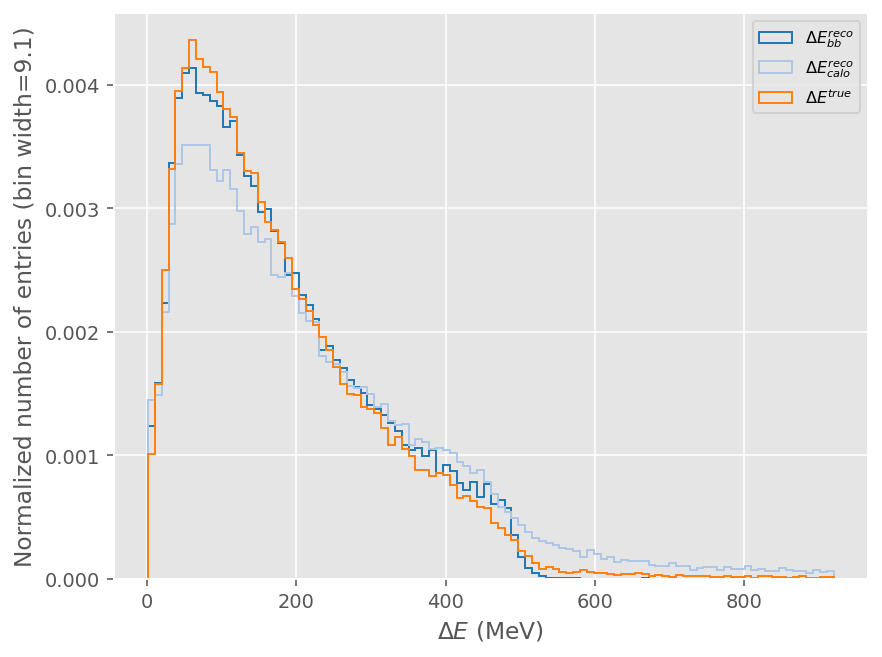

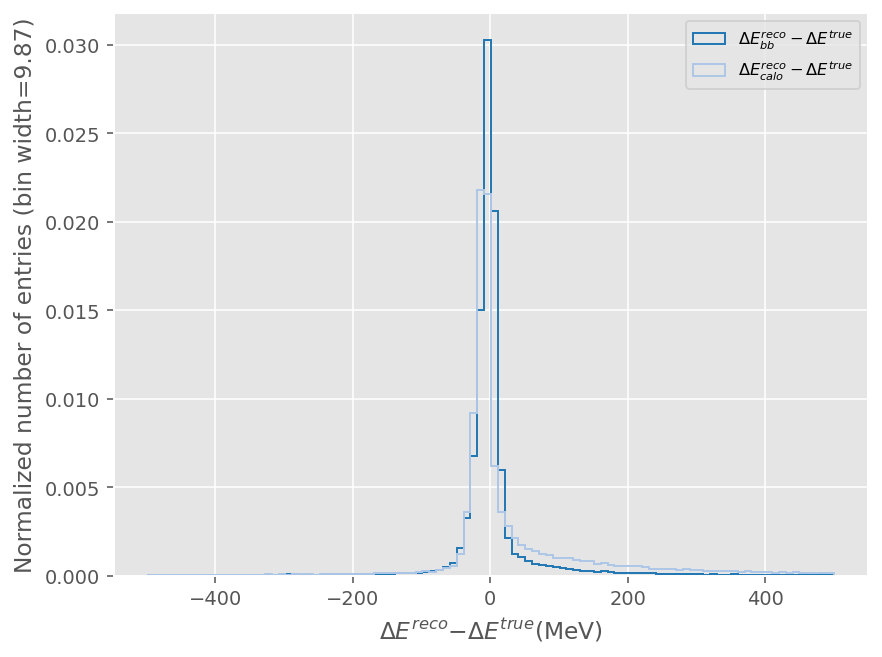

In [24]:
plot_labels = [labels.Delta_E_reco_bb, labels.Delta_E_reco_calo, labels.Delta_E_true]
Plots.PlotHistComparison([dE_bb, dE_calo, dE_true], labels = plot_labels, xlabel = "$\Delta E$ (MeV)")
Save()
Plots.PlotHistComparison([dE_bb - dE_true, dE_calo - dE_true], labels = [plot_labels[0][:-1] + "-" + plot_labels[2][1:], plot_labels[1][:-1] + "-" + plot_labels[2][1:]], xRange = [-500, 500], xlabel = labels.Delta_E_reco + "$-$" + labels.Delta_E_true + labels.MeV)
Save()

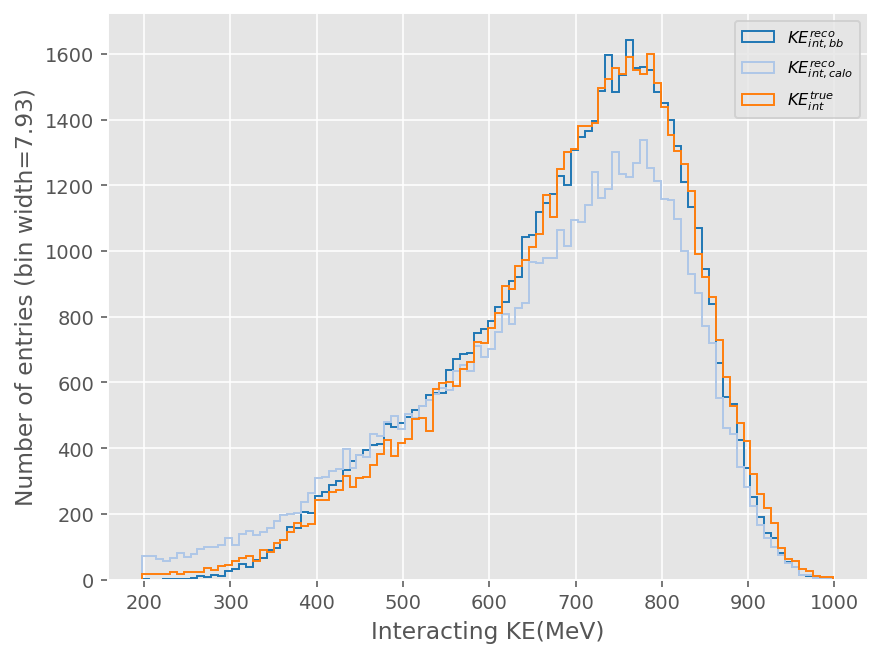

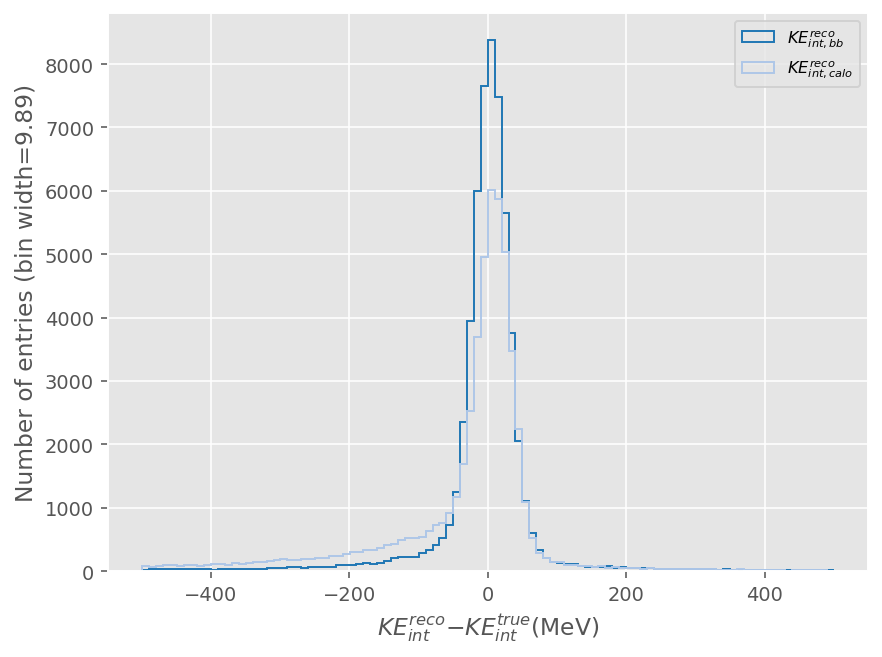

In [25]:
plot_labels = [labels.KE_reco_int_bb, labels.KE_reco_int_calo, labels.KE_true_int]
Plots.PlotHistComparison([reco_ffKE - dE_bb, reco_ffKE - dE_calo, mc.trueParticles.beam_traj_KE[:, -2]], labels = plot_labels, xlabel = "Interacting KE" + labels.MeV, xRange = [0, 1000], density = False)
Save()
Plots.PlotHistComparison([reco_ffKE - dE_bb - mc.trueParticles.beam_traj_KE[:, -2], reco_ffKE - dE_calo - mc.trueParticles.beam_traj_KE[:, -2]], labels = plot_labels[:-1], xRange = [-500, 500], xlabel = labels.KE_reco_int + "$-$" + labels.KE_true_int + labels.MeV, density = False)
Save()

In [26]:
pdf.close()

NameError: name 'pdf' is not defined